In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
import cupy as cp

sys.path.append(os.path.abspath(os.path.join('..')))

from models.utils import train_val_test_split
from models.neural_net import NeuralNetwork
from models.constants import *


In [13]:
X_images = np.load("../data/X_images.npy ")
X_images = X_images / NORMALIZATION_FACTOR
print(X_images.shape)

y_images = np.load("../data/y_images.npy ")
print(y_images.shape)

X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_images, y_images)

X_train = cp.asarray(X_train)
y_train = cp.asarray(y_train)
X_val = cp.asarray(X_val)
y_val = cp.asarray(y_val)
X_test = cp.asarray(X_test)
y_test = cp.asarray(y_test)

(5000, 784)
(5000,)


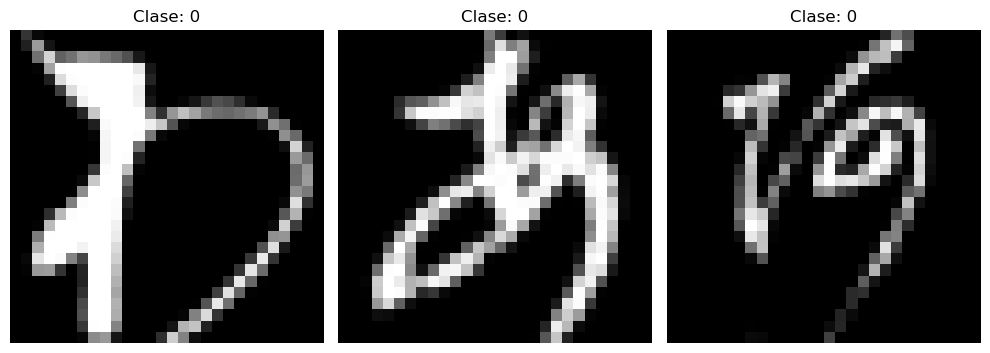

In [14]:
# Visualizar las primeras 3 imágenes del dataset
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i in range(3):
    img = X_images[i].reshape(28, 28)  # Reconvertir a matriz 28x28
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Clase: {y_images[i]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


### M0

In [15]:
model = NeuralNetwork(layer_sizes=[784, 100, 80, NUM_CLASSES])

history = model.train(
    X_train, y_train,
    X_val, y_val,
    lr=0.01,
    epochs=5000,
    early_stopping=True,
    patience=20
)

Training:  82%|████████████████████████████████████████▎        | 4109/5000 [01:07<00:14, 60.86it/s]


train_loss [array(4.06614546), array(4.05931289), array(4.05278662), array(4.04654172), array(4.04056028), array(4.03477702), array(4.02920502), array(4.02383078), array(4.01863452), array(4.01360852), array(4.00872465), array(4.00396405), array(3.99934568), array(3.99486734), array(3.99052619), array(3.98630179), array(3.98218531), array(3.97819001), array(3.97430315), array(3.97050696), array(3.96679595), array(3.96317156), array(3.95963784), array(3.95618042), array(3.9527998), array(3.9494868), array(3.94623774), array(3.9430622), array(3.93995562), array(3.93691076), array(3.93391809), array(3.93097766), array(3.928096), array(3.92527962), array(3.9225047), array(3.91977492), array(3.91708822), array(3.91444255), array(3.9118547), array(3.90931299), array(3.90681329), array(3.90434484), array(3.90189871), array(3.89948487), array(3.89710557), array(3.89477254), array(3.89247744), array(3.89021157), array(3.88797268), array(3.88576233), array(3.88357835), array(3.88141551), array(3

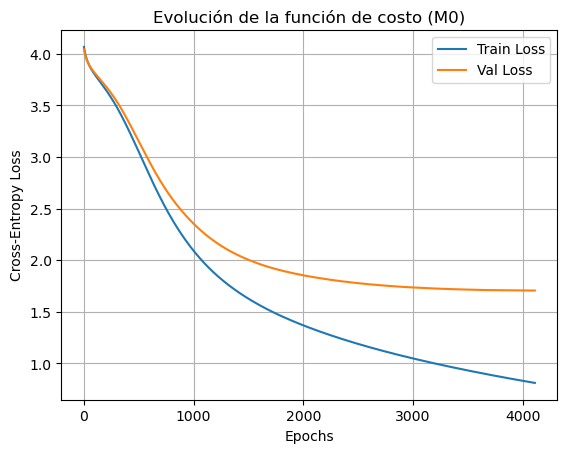

In [ ]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.title("Evolución de la función de costo (M0)")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Evaluación completa en train y validation
model.evaluate_metrics(X_train, y_train, title_prefix="Train")
model.evaluate_metrics(X_val, y_val, title_prefix="Validation")

TypeError: 'ndarray' object cannot be interpreted as an integer